In [1]:
import sys
import ROOT
import numpy as np
import pandas as pd
import root_pandas
import seaborn as sb
import matplotlib.pyplot as plt
import uproot
import time

from itertools import product

#from root_numpy import root2array

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import QuantileTransformer
import pickle

Welcome to JupyROOT 6.16/00


/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.3 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using TensorFlow backend.


In [2]:
#######################################################
### ADD TARGET COLUMNS AND SAVE CSV FILES OF EVENTS ###
#######################################################
features = [
    'm2_miss', #missing mass square (p_B - p_mu1 - p_mu2 - p_mu)^2
    'muE_Brf', #mu energy in the Bc rest frame
    'q2', #squared 4momentum transfer to lepton sys (p_B - p_mu1 - p_mu2)^2
    'pT_miss', #missing transverse momentum (p_B - p_mu1 - p_mu2 - p_mu).Pt
    'mu_pt'     ,
    'mu_eta'    ,
    'mu_phi'    ,
    #'mu_charge' ,
    'mu1_pt'    ,
    'mu1_eta'   ,
    'mu1_phi'   ,
    #'mu1_charge',
    'mu2_pt'    ,
    'mu2_eta'   ,
    'mu2_phi'   ,
    #'mu2_charge',
]

mu_events = pd.read_csv('mu_events.csv')
tau_events = pd.read_csv('tau_events.csv')

mu_events['target'] = 0
tau_events['target'] = 1

In [3]:
#########################################
### PREPARE DFs FOR TRAINING AND TEST ###
#########################################

# concatenate the two samples
dataset = pd.concat([mu_events, tau_events],sort=False)

# shuffle and split train/test
train, test = train_test_split(dataset, test_size=0.85, random_state=1986, shuffle=True)

# X and Y on the training sample
X = pd.DataFrame(train, columns=features)
Y = pd.DataFrame(train, columns=['target'])

In [4]:
##################
### PREPROCESS ###
##################


qt = QuantileTransformer(output_distribution='normal', random_state=1986)
qt.fit(X[features])
transformedX = pd.DataFrame(qt.transform(X[features]),columns=features)
pickle.dump( qt, open( 'quantile_tranformation.pck', 'w' ) )

In [5]:
########################
### DEFINE THE MODEL ###
########################

# model defined and fitted with parameters set with BAYESIAN OPTIMIZATION

# define the model
model = Sequential()
for i in range(1):
    model.add(Dense(16, input_dim=len(features),activation='relu'))
model.add(Dense(1,activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
#######################
### TRAIN THE MODEL ###
#######################


# fit the model
model.fit(transformedX, Y, epochs=20, batch_size=5, validation_split=0.5)

Instructions for updating:
Use tf.cast instead.
Train on 30492 samples, validate on 30493 samples
Epoch 1/20
30492/30492 [==============================] - 15s 506us/step - loss: 0.2553 - acc: 0.8930 - val_loss: 0.2403 - val_acc: 0.8986
Epoch 2/20
30492/30492 [==============================] - 11s 360us/step - loss: 0.2310 - acc: 0.9012 - val_loss: 0.2364 - val_acc: 0.8990s - loss: 
Epoch 3/20
30492/30492 [==============================] - 10s 344us/step - loss: 0.2290 - acc: 0.9022 - val_loss: 0.2356 - val_acc: 0.9003
Epoch 4/20
30492/30492 [==============================] - 10s 339us/step - loss: 0.2276 - acc: 0.9034 - val_loss: 0.2356 - val_acc: 0.8999
Epoch 5/20
30492/30492 [==============================] - 10s 344us/step - loss: 0.2268 - acc: 0.9032 - val_loss: 0.2358 - val_acc: 0.9000A: 1s - loss: 0.2253 - - ETA: 0s - loss: 0.2269 - acc: 0.902 - ETA: 0s - loss: 0.2267 -
Epoch 6/20
30492/30492 [==============================] - 10s 343us/step - loss: 0.2261 - acc: 0.9040 - val_lo

2019-07-17 09:35:35.612576: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [7]:
######################################
### TEST THE TRAINING OF THE MODEL ###
######################################


# evaluate the model
scores = model.evaluate(transformedX, Y)
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# calculate predictions on the test sample
print 'predicting on', test.shape[0], 'events'
x = pd.DataFrame(test, columns=features)
qt = pickle.load(open( 'quantile_tranformation.pck', 'r' ))
transformedx = qt.transform(x[features])
y = model.predict(transformedx)

# add the score to the test sample dataframe
test.insert(len(test.columns), 'nn_score', y)

60985/60985 [==============================] - 1s 14us/step

loss: 22.79%
acc: 90.34%
predicting on 345588 events


In [8]:
#################
### ROC CURVE ###
#################


# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(test.target, test.nn_score)

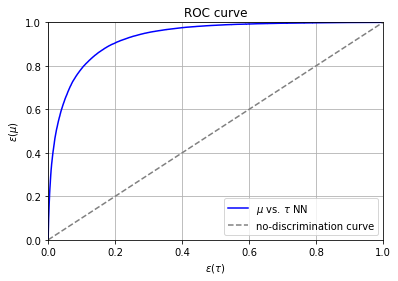

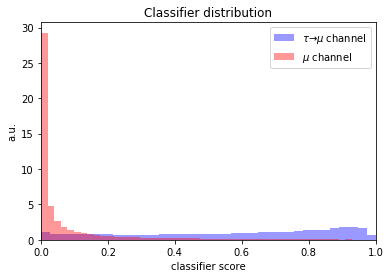

<Figure size 432x288 with 0 Axes>

In [9]:
##########################
### ROC & SCORE CURVES ###
##########################


# plot
plt.plot(fpr, tpr, label=r'$\mu$ vs. $\tau$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
plt.title('ROC curve')
plt.xlabel(r'$\epsilon(\tau)$')
plt.ylabel(r'$\epsilon(\mu)$')
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best')
# save figure and then clean it
#plt.savefig('selectionNN_roc.pdf')
plt.show()
#plt.clf()

# plot the discriminator shape for the muon and tau channel
test_tau = test[test.target==1]
test_mu  = test[test.target==0]
sb.distplot(test_tau['nn_score'], kde=False, norm_hist=True, label=r'$\tau\to\mu$ channel', color='b')
sb.distplot(test_mu ['nn_score'], kde=False, norm_hist=True, label=r'$\mu$ channel' , color='r')
plt.title('Classifier distribution')
plt.xlabel('classifier score')
plt.ylabel('a.u.')
plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 0.25])
plt.legend(loc='upper right')
#plt.savefig('selectionNN_score.pdf')
plt.show()
plt.clf()

In [10]:
# compute the auc
auroc = auc(fpr, tpr)
print "AUC =", auroc 

# compute Gini index
print "Gini index =", (auroc-0.5)*2

AUC = 0.9311590756044551
Gini index = 0.8623181512089102


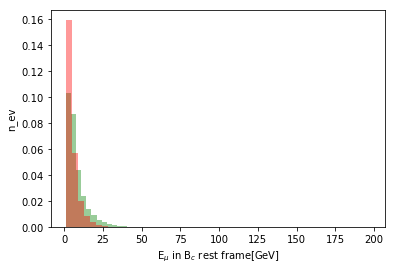

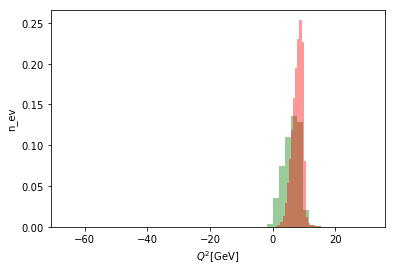

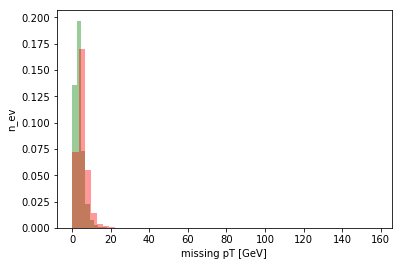

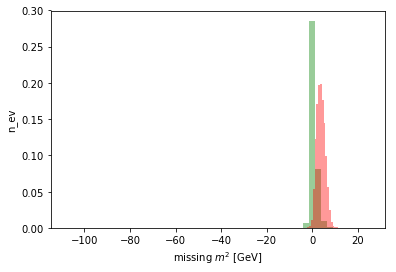

In [11]:
sb.distplot(mu_events['muE_Brf'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_events['muE_Brf'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('E$_{\mu}$ in B$_c$ rest frame[GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_events['q2'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_events['q2'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$Q^2$[GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_events['pT_miss'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_events['pT_miss'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('missing pT [GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_events['m2_miss'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_events['m2_miss'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('missing $m^2$ [GeV]')
plt.ylabel('n_ev')
#plt.ylim([0,3e-8])
plt.show()

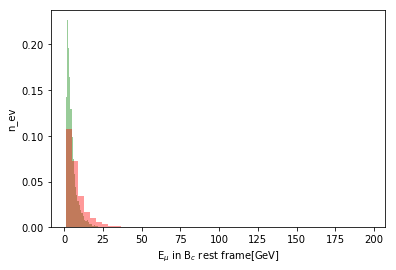

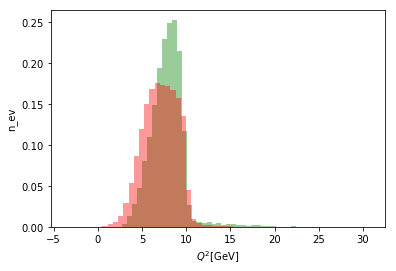

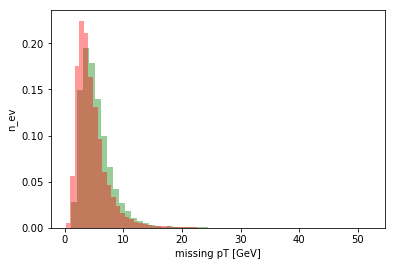

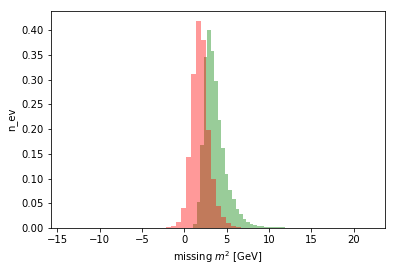

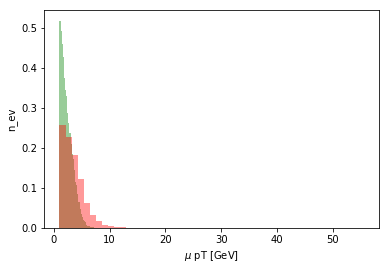

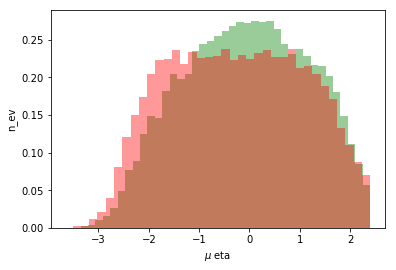

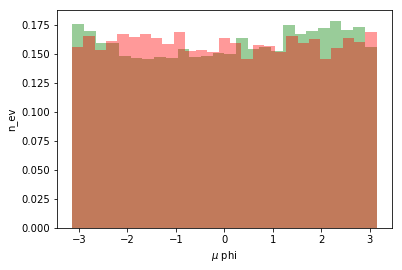

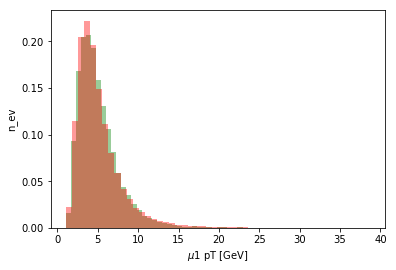

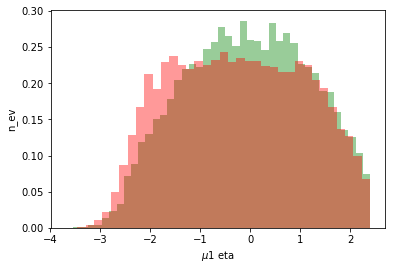

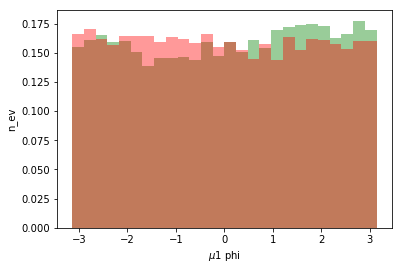

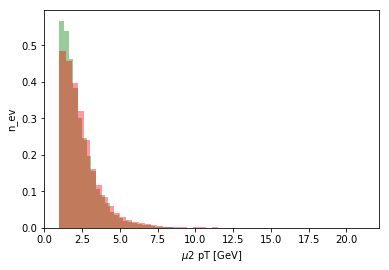

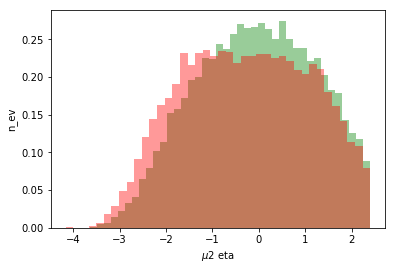

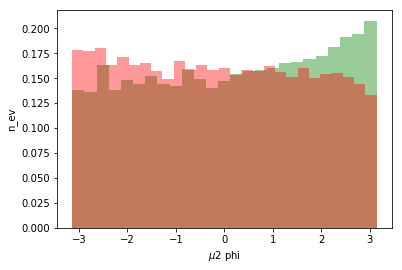

In [12]:
#############################################################################
### CONTROL HOW THE DISTRIBUTIONS OF THE WRONGLY ASSIGNED EVENTS ARE DONE ###
#############################################################################


mu_wrong = pd.DataFrame()
tau_wrong = pd.DataFrame()

i = 0
k = 0
for j in test_mu.index:
    if test_mu.at[j,'nn_score'] > 0.4:
        mu_wrong.at[i,'mu1_pt'] = test_mu.at[j,'mu1_pt']
        mu_wrong.at[i,'mu1_eta'] = test_mu.at[j,'mu1_eta']
        mu_wrong.at[i,'mu1_phi'] = test_mu.at[j,'mu1_phi']
        mu_wrong.at[i,'mu2_pt'] = test_mu.at[j,'mu2_pt']
        mu_wrong.at[i,'mu2_eta'] = test_mu.at[j,'mu2_eta']
        mu_wrong.at[i,'mu2_phi'] = test_mu.at[j,'mu2_phi']
        mu_wrong.at[i,'mu_pt'] = test_mu.at[j,'mu_pt']
        mu_wrong.at[i,'mu_eta'] = test_mu.at[j,'mu_eta']
        mu_wrong.at[i,'mu_phi'] = test_mu.at[j,'mu_phi']
        mu_wrong.at[i,'m2_miss'] = test_mu.at[j,'m2_miss']
        mu_wrong.at[i,'pT_miss'] = test_mu.at[j,'pT_miss']
        mu_wrong.at[i,'q2'] = test_mu.at[j,'q2']
        mu_wrong.at[i,'muE_Brf'] = test_mu.at[j,'muE_Brf']
        mu_wrong.at[i,'muon_pair'] = test_mu.at[j,'muon_pair']
        i += 1
for j in test_tau.index:
    if test_tau.at[j,'nn_score'] < 0.4:
        tau_wrong.at[k,'mu1_pt'] = test_tau.at[j,'mu1_pt']
        tau_wrong.at[k,'mu1_eta'] = test_tau.at[j,'mu1_eta']
        tau_wrong.at[k,'mu1_phi'] = test_tau.at[j,'mu1_phi']
        tau_wrong.at[k,'mu2_pt'] = test_tau.at[j,'mu2_pt']
        tau_wrong.at[k,'mu2_eta'] = test_tau.at[j,'mu2_eta']
        tau_wrong.at[k,'mu2_phi'] = test_tau.at[j,'mu2_phi']
        tau_wrong.at[k,'mu_pt'] = test_tau.at[j,'mu_pt']
        tau_wrong.at[k,'mu_eta'] = test_tau.at[j,'mu_eta']
        tau_wrong.at[k,'mu_phi'] = test_tau.at[j,'mu_phi']
        tau_wrong.at[k,'m2_miss'] = test_tau.at[j,'m2_miss']
        tau_wrong.at[k,'pT_miss'] = test_tau.at[j,'pT_miss']
        tau_wrong.at[k,'q2'] = test_tau.at[j,'q2']
        tau_wrong.at[k,'muE_Brf'] = test_tau.at[j,'muE_Brf']
        tau_wrong.at[k,'muon_pair'] = test_tau.at[j,'muon_pair']
        k += 1
        
sb.distplot(mu_wrong['muE_Brf'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['muE_Brf'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('E$_{\mu}$ in B$_c$ rest frame[GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['q2'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['q2'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$Q^2$[GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['pT_miss'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['pT_miss'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('missing pT [GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['m2_miss'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['m2_miss'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('missing $m^2$ [GeV]')
plt.ylabel('n_ev')
#plt.ylim([0,3e-8])
plt.show()

sb.distplot(mu_wrong['mu_pt'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['mu_pt'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu$ pT [GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['mu_eta'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['mu_eta'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu$ eta')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['mu_phi'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['mu_phi'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu$ phi')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['mu1_pt'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['mu1_pt'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu1$ pT [GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['mu1_eta'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['mu1_eta'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu1$ eta')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['mu1_phi'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['mu1_phi'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu1$ phi')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['mu2_pt'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['mu2_pt'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu2$ pT [GeV]')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['mu2_eta'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['mu2_eta'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu2$ eta')
plt.ylabel('n_ev')
plt.show()

sb.distplot(mu_wrong['mu2_phi'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau_wrong['mu2_phi'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu2$ phi')
plt.ylabel('n_ev')
plt.show()
